In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from nn_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [13]:
filename = "datasets/breast-cancer-wisconsin.data"
dataset = np.genfromtxt(filename, delimiter=",")
#splitting given data into a training set and testing set
train_set = dataset[:350]
test_set = dataset[350:]

#splitting both sets into input matrix and label matrix, the set[:, 1:-1] removes the id number from the list of parameters since it is irrelevant
train_set_X, train_set_Y = train_set[:, 1:-1], train_set[:, -1]
test_set_X, test_set_Y = test_set[:, 1:-1], test_set[:, -1]
train_set_X, train_set_Y = train_set_X.T, train_set_Y.reshape(1, train_set_Y.shape[0])
test_set_X, test_set_Y = test_set_X.T, test_set_Y.reshape(1, test_set_Y.shape[0])

#label column has entries of 2 and 4, so dividing by 2 and subtracting 1 gives binary values 0 and 1
train_set_Y, test_set_Y = (train_set_Y/2)-1, (test_set_Y/2)-1

print("Training data input shape: ", train_set_X.shape)
print("Training data label shape: ", train_set_Y.shape)
print("Testing data input shape: ", test_set_X.shape)
print("Testing data label shape: ", test_set_Y.shape)

Training data input shape:  (9, 350)
Training data label shape:  (1, 350)
Testing data input shape:  (9, 333)
Testing data label shape:  (1, 333)


Cost after iteration 0: 0.513706
Cost after iteration 100: 0.438457
Cost after iteration 200: 0.382969
Cost after iteration 300: 0.344121
Cost after iteration 400: 0.317423
Cost after iteration 500: 0.297628
Cost after iteration 600: 0.281199
Cost after iteration 700: 0.266403
Cost after iteration 800: 0.253672
Cost after iteration 900: 0.242557
Cost after iteration 1000: 0.232603
Cost after iteration 1100: 0.223593
Cost after iteration 1200: 0.215245
Cost after iteration 1300: 0.207459
Cost after iteration 1400: 0.200507
Cost after iteration 1500: 0.194192
Cost after iteration 1600: 0.188380
Cost after iteration 1700: 0.183000
Cost after iteration 1800: 0.178017
Cost after iteration 1900: 0.173419
Cost after iteration 2000: 0.169112
Cost after iteration 2100: 0.165053
Cost after iteration 2200: 0.161211
Cost after iteration 2300: 0.157554
Cost after iteration 2400: 0.154072
Cost after iteration 2500: 0.150753
Cost after iteration 2600: 0.147592
Cost after iteration 2700: 0.144569
Cost

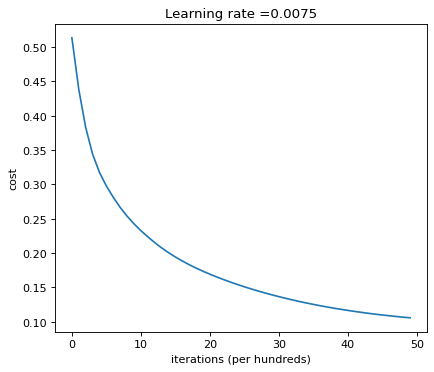

In [14]:

layers_dims = [9, 7, 5, 1]

def my_L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize = (6,5), dpi = 80)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters_basic = my_L_layer_model(train_set_X, train_set_Y, layers_dims, num_iterations = 5000, print_cost = True)

In [15]:
print("Accuracy on training set:")
pred_train_basic = predict(train_set_X, train_set_Y, parameters_basic)
print("Accuracy on test set:")
pred_test_basic = predict(test_set_X, test_set_Y, parameters_basic)

Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.987987987987988


The accuracy is quite good, but the cost after many iterations is still quite large, so I'd like to make some improvements to reduce that. I'll try implementing gradient descent with momentum to see if that improves the cost. 
I define 2 new functions in nn_functions.py: 
- initialize_parameters_momentum(), a slightly modified version of initialize_parameters(), where sDw is initialized as a matrix of zeros instead of random values.
- update_parameters_momentum(), a modified version of update_parameters(), where the average of the gradients is recorded, and gradient descent with momentum is implemented.


Cost after iteration 0: 0.513706
Cost after iteration 100: 0.443912
Cost after iteration 200: 0.386891
Cost after iteration 300: 0.346469
Cost after iteration 400: 0.318879
Cost after iteration 500: 0.298733
Cost after iteration 600: 0.282263
Cost after iteration 700: 0.267329
Cost after iteration 800: 0.254431
Cost after iteration 900: 0.243240
Cost after iteration 1000: 0.233226
Cost after iteration 1100: 0.224172
Cost after iteration 1200: 0.215844
Cost after iteration 1300: 0.208018
Cost after iteration 1400: 0.200999
Cost after iteration 1500: 0.194652
Cost after iteration 1600: 0.188823
Cost after iteration 1700: 0.183428
Cost after iteration 1800: 0.178431
Cost after iteration 1900: 0.173816
Cost after iteration 2000: 0.169503
Cost after iteration 2100: 0.165441
Cost after iteration 2200: 0.161600
Cost after iteration 2300: 0.157945
Cost after iteration 2400: 0.154470
Cost after iteration 2500: 0.151148
Cost after iteration 2600: 0.147985
Cost after iteration 2700: 0.144960
Cost

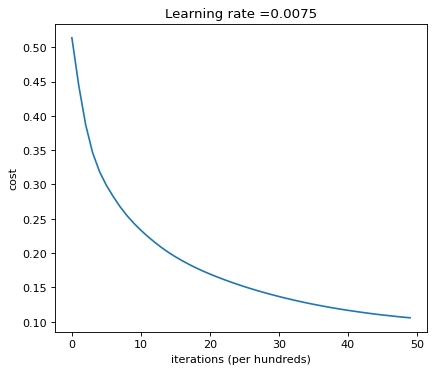

In [16]:
layers_dims = [9, 7, 5, 1]

def my_L_layer_model_momentum(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_momentum(parameters, grads, learning_rate, gradsAvg, beta)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize = (6,5), dpi = 80)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, num_iterations = 5000, print_cost = True)

In [17]:
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)

Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.987987987987988


Interestingly, using gradient descent with momentum slightly increased the cost rather than lowering it. This might be because of the value chosen for beta (0.9), but before I adjust this value, I will try to implement RMSprop as well, to see if that changes anything first.
For this, I define 1 extra function called update_parameters_RMSprop(), and I reuse the function for creating parameters from my model using momentum.

Cost after iteration 0: 0.513706
Cost after iteration 100: 0.139457
Cost after iteration 200: 0.097761
Cost after iteration 300: 0.085353
Cost after iteration 400: 0.078663
Cost after iteration 500: 0.071581
Cost after iteration 600: 0.058095
Cost after iteration 700: 0.046877
Cost after iteration 800: 0.039714
Cost after iteration 900: 0.072852
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan


d:\download\code\cmpt 310 finalproject\nn_functions.py:243: RuntimeWarning: divide by zero encountered in log
  cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
d:\download\code\cmpt 310 finalproject\nn_functions.py:328: RuntimeWarning: invalid value encountered in divide
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))


Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
Cost after iteration 2000: nan
Cost after iteration 2100: nan
Cost after iteration 2200: nan
Cost after iteration 2300: nan
Cost after iteration 2400: nan


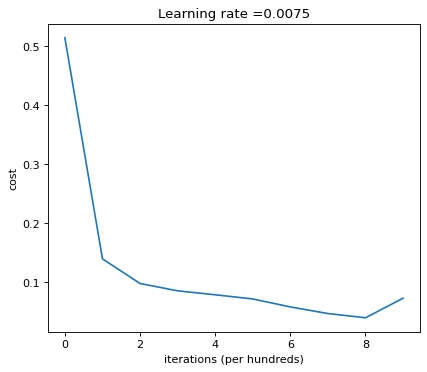

In [18]:
layers_dims = [9, 7, 5, 1]

def my_L_layer_model_RMSprop(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    parameters = initialize_parameters_deep(layers_dims)

    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_RMSprop(parameters, grads, learning_rate, gradsAvg, beta)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize = (6,5), dpi = 80)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, num_iterations = 2500, print_cost = True)

In [19]:
print("Accuracy on training set:")
pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
print("Accuracy on test set:")
pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)

Accuracy on training set:
Accuracy: 0.5314285714285715
Accuracy on test set:
Accuracy: 0.7747747747747747


In this model, the loss function sharply declined and then became NaN. I did a bit of research into this, and this is likely a case of an exploding gradient problem, an issue in machine learning where when the gradients are large, multiplication of these gradients become huge as the process continues. So even though the loss is low, this model will likely not perform well. A proposed fix to this is to adjust hyperparameters.

Given that I have 2 models to work with, gradient descent with momentum and gradient descent using RMSprop, I will adjust hyperparameters for both to see which performs better overall. I will first start with my momentum model.

In [20]:
layers_dims = [9,7,5,1]

In [21]:
def my_L_layer_model_momentum(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, plot_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_momentum(parameters, grads, learning_rate, gradsAvg, beta)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    if(plot_cost):
        plt.figure(figsize = (6,5), dpi = 80)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

The following code experiments with what happens as the values of beta and the learning rate change. Changing both parameters at the same time allows for more values to be checked overall, and once I find a interesting result, I can hone in on that area.

In [22]:
# Your work for experiments
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.99-i*0.2, 0.0075+i*0.0005, num_iterations = 2500)
    print("beta =", 0.99-i*0.2, "learning rate =", 0.0075+i*0.0005)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")
    

beta = 0.99 learning rate = 0.0075
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.79 learning rate = 0.008
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.59 learning rate = 0.0085
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.3899999999999999 learning rate = 0.009
Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.18999999999999995 learning rate = 0.0095
Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.9759759759759761



The accuracy increased as the learning rate increased and beta decreased. I will test what happens when the learning rate decreases and beta increased, to investigate the relationship between the two values. 

In [23]:
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.19-i*0.2, 0.00789+i*0.0002, num_iterations = 2500)
    print("beta =", 0.19+i*0.2, "learning rate =", 0.00789-i*0.0002)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")
    

beta = 0.19 learning rate = 0.00789
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.39 learning rate = 0.00769
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.5900000000000001 learning rate = 0.007489999999999999
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.79 learning rate = 0.00729
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.99 learning rate = 0.007089999999999999
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973



A similar result occurs, which means that one of these values does not affect the accuracy much. So I change the values on their own to see which is causing the change in accuracy.

In [24]:
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.19-i*0.02, 0.0075, num_iterations = 2500)
    print("beta =", 0.19+i*0.2)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.005+i*0.01, num_iterations = 2500)
    print("learning rate =", 0.0075+i*0.01)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")

beta = 0.19
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.39
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.5900000000000001
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.79
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.99
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

learning rate = 0.0075
Accuracy on training set:
Accuracy: 0.9514285714285714
Accuracy on test set:
Accuracy: 0.9669669669669669

learning rate = 0.0175
Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.987987987987988

learning rate = 0.0275
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.987987987987988

learning rate = 0.0375
Accuracy on training set:
Accuracy: 0.9714285714285713
Accur

There is not enough room for the results to show here, but upon viewing the output in the text editor, it seems that changing the value of beta does not affect much, while changing the learning rate improves the accuracy quite a lot. From some tedious experimenting with the learning rate, I found that increasing the learning rate too much increases accuracy on the training set, but starts to reduce accuracy on the test set, which is a case of overfitting the data. A good value that I found for the learning rate was around 0.0375. This value maximized accuracy on both the training set as well as the test set.

In [25]:
print("Original hyperparameters:")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0075, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
print("")
print("Optimized hyperparameters:")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)

Original hyperparameters:
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

Optimized hyperparameters:
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.987987987987988


Now I will do some experimenting with my RMSprop model. The issue with this model is that it experiences a case of gradient explosion, so to combat this, I will adjust the learning rate to account for the large gradients.

In [26]:
def my_L_layer_model_RMSprop(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, plot_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    parameters = initialize_parameters_deep(layers_dims)

    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_RMSprop(parameters, grads, learning_rate, gradsAvg, beta)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    if(plot_cost):
        plt.figure(figsize = (6,5), dpi = 80)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [27]:
for i in range(5):
    parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.0075/(i+1), num_iterations = 2500)
    print("learning rate =", 0.0075/(i+1))
    print("Accuracy on training set:")
    pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
    print("Accuracy on test set:")
    pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)
    print("")

learning rate = 0.0075
Accuracy on training set:
Accuracy: 0.5314285714285715
Accuracy on test set:
Accuracy: 0.7747747747747747

learning rate = 0.00375
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9759759759759761

learning rate = 0.0025
Accuracy on training set:
Accuracy: 0.9828571428571429
Accuracy on test set:
Accuracy: 0.9789789789789791

learning rate = 0.001875
Accuracy on training set:
Accuracy: 0.98
Accuracy on test set:
Accuracy: 0.9789789789789791

learning rate = 0.0015
Accuracy on training set:
Accuracy: 0.98
Accuracy on test set:
Accuracy: 0.9759759759759761



It seems that the gradient explosion issue is fixed by reducing the learning rate. I did some tedious experimenting with the learning rate, and it seems that the optimal value is around 0.00235.

In [28]:
parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.00235, num_iterations = 2500)
print("learning rate =", 0.00235)
print("Accuracy on training set:")
pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
print("Accuracy on test set:")
pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)

learning rate = 0.00235
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791


I will do some experimenting with beta to see if I can further increase the accuracy.

In [29]:
for i in range(5):
    parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9-i*0.2, 0.00235, num_iterations = 2500)
    print("beta = ", 0.9-i*0.2)
    print("Accuracy on training set:")
    pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
    print("Accuracy on test set:")
    pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)
    print("")

beta =  0.9
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791

beta =  0.7
Accuracy on training set:
Accuracy: 0.98
Accuracy on test set:
Accuracy: 0.9789789789789791

beta =  0.5
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9759759759759761

beta =  0.29999999999999993
Accuracy on training set:
Accuracy: 0.9799999999999999
Accuracy on test set:
Accuracy: 0.9789789789789791

beta =  0.09999999999999998
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.9789789789789791



As beta decreases, the accuracy worsens. I also tested to see what would happen if I moved beta closer to 1, but as it got closer to 1, the accuracy also worsened. So I think an optimal value for beta is 0.9.

In [30]:
print("Momentum model: ")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
print("")
print("RMSprop model:")
parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.00235, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
print("Accuracy on test set:")
pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)


Momentum model: 
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.987987987987988

RMSprop model:
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791


These are the results after optimizing values for the learning rate and beta. Finally, I will see if changing the size of the training set and testing set will change anything. Below, I reprocess the data, and run the model again with differently sized sets.

In [31]:
filename = "datasets/breast-cancer-wisconsin.data"
dataset = np.genfromtxt(filename, delimiter=",")
for i in range(5):
    #splitting given data into a training set and testing set
    train_set = dataset[:350+i*50]
    test_set = dataset[350+i*50:]

    #splitting both sets into input matrix and label matrix, the set[:, 1:-1] removes the id number from the list of parameters since it is irrelevant
    train_set_X, train_set_Y = train_set[:, 1:-1], train_set[:, -1]
    test_set_X, test_set_Y = test_set[:, 1:-1], test_set[:, -1]
    train_set_X, train_set_Y = train_set_X.T, train_set_Y.reshape(1, train_set_Y.shape[0])
    test_set_X, test_set_Y = test_set_X.T, test_set_Y.reshape(1, test_set_Y.shape[0])

    #label coloumn has entries of 2 and 4, so dividing by 2 and subtracting 1 gives binary values 0 and 1
    train_set_Y, test_set_Y = (train_set_Y/2)-1, (test_set_Y/2)-1

    print("TRAIN SET OF SIZE:", 350+i*50, ",", "TEST SET OF SIZE:", 683-(350+i*50))
    print("Momentum model: ")
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("RMSprop model:")
    parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.00235, num_iterations = 2500)
    print("Accuracy on training set:")
    pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
    print("Accuracy on test set:")
    pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)
    print("")
    print("")





TRAIN SET OF SIZE: 350 , TEST SET OF SIZE: 333
Momentum model: 
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.987987987987988
RMSprop model:
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791


TRAIN SET OF SIZE: 400 , TEST SET OF SIZE: 283
Momentum model: 
Accuracy on training set:
Accuracy: 0.9724999999999999
Accuracy on test set:
Accuracy: 0.9858657243816256
RMSprop model:
Accuracy on training set:
Accuracy: 0.5700000000000001
Accuracy on test set:
Accuracy: 0.7632508833922262


TRAIN SET OF SIZE: 450 , TEST SET OF SIZE: 233
Momentum model: 
Accuracy on training set:
Accuracy: 0.9666666666666668
Accuracy on test set:
Accuracy: 0.9828326180257514
RMSprop model:
Accuracy on training set:
Accuracy: 0.9888888888888889
Accuracy on test set:
Accuracy: 0.9785407725321891


TRAIN SET OF SIZE: 500 , TEST SET OF SIZE: 183
Momentum model: 
Accuracy on training set:
Accuracy: 0.9720000000000003
Acc

The output exceeds the size limit, but according to the data, generally increasing the size of the training set and decreasing the size of the test set resulted in better accuracy on both sets. However, the RMSprop model had lower accuracy in all cases when compared against the momentum model. So I will use my momentum model for my final model. After some experimentation, I found that the setting the training set size to around 515, and the test set size to around 168, resulted in the highest accuracy. 

In [32]:
filename = "datasets/breast-cancer-wisconsin.data"
dataset = np.genfromtxt(filename, delimiter=",")
#splitting given data into a training set and testing set
train_set = dataset[:515]
test_set = dataset[515:]

#splitting both sets into input matrix and label matrix, the set[:, 1:-1] removes the id number from the list of parameters since it is irrelevant
train_set_X, train_set_Y = train_set[:, 1:-1], train_set[:, -1]
test_set_X, test_set_Y = test_set[:, 1:-1], test_set[:, -1]
train_set_X, train_set_Y = train_set_X.T, train_set_Y.reshape(1, train_set_Y.shape[0])
test_set_X, test_set_Y = test_set_X.T, test_set_Y.reshape(1, test_set_Y.shape[0])

#label coloumn has entries of 2 and 4, so dividing by 2 and subtracting 1 gives binary values 0 and 1
train_set_Y, test_set_Y = (train_set_Y/2)-1, (test_set_Y/2)-1

print("TRAIN SET OF SIZE:", 515, ",", "TEST SET OF SIZE:", 168)
print("Momentum model: ")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)

TRAIN SET OF SIZE: 515 , TEST SET OF SIZE: 168
Momentum model: 
Accuracy on training set:
Accuracy: 0.9786407766990293
Accuracy on test set:
Accuracy: 0.9999999999999999


This resulted in a very good accuracy for the test set, this is a satisfying result, so my experimentation ends here. However, this incredibly high accuracy on the test set could be due to the relatively small amount of data my dataset consisted of, so this model might not have such high accuracy if given more data, but as the model does incredibly well on the given data, concluding experimentation here is fine.